# Object Detection

This object detection model has trained over public dataset "https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet" containing labeled mask images.

## About the data

There are total 1,510 images.

The data consist of images files and respective annotation files. Each annotation file has one or more lines in which we can find the class and bounding box coordinates:

### Image
![Alt text](data/obj/1-with-mask.jpg)

### Annotation
`0 0.5 0.6455882352941177 0.30980392156862746 0.40294117647058825`

Here, first element is object class, `0` is for "Mask" and `1` is for "No Mask", and rest of 4 elements are coordinates of bounding boxes.

## Importing libraries

In [7]:
# importing libraries

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging
print(tf.__version__)

2.13.0


## Data Preprocessing

Let's first segregate all files into 3 categories:

- Training files (70% of images)
- Validation files (25% of images)
- Test files (remaining 5%)

We have observed that the image data is more skewed towards "Mask" instances in comparison to "Non-Mask" instances.

In [3]:
# Function to segregate images into training, validation and test set

def list_files(full_data_path = "data/obj", image_ext = '.jpg', split_percentage = [70, 25]):

    masked_files = []
    non_masked_files = []

    # variable to count images that has been discarded
    discarded = 0

    # variable to count images with mask
    masked_instance = 0

    # iterating for all files in dataset folder
    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # discarding images those have more than one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue

                strip = file[0:len(file) - len(".txt")]
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' means non-mask
                    # and then segregating them to separate lists
                    if lines[0][0] == '0':
                        masked_instance += 1
                        masked_files.append(strip)
                    else:
                        non_masked_files.append(strip)


    size = len(masked_files) + len(non_masked_files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    # used sampling stategy in order to keep the ratio of masked
    # and non-masked instances same as that of original data in train, val and test sets respectively.
    masked_training_split = int(split_percentage[0] * len(masked_files) / 100)
    non_masked_training_split = int(split_percentage[0] * len(non_masked_files) / 100)

    training = masked_files[0:masked_training_split] + non_masked_files[0:non_masked_training_split]

    masked_validation_split = masked_training_split + int(split_percentage[1] * len(masked_files) / 100)
    non_masked_validation_split = non_masked_training_split + int(split_percentage[1] * len(non_masked_files) / 100)

    validation = masked_files[masked_training_split:masked_validation_split] + non_masked_files[non_masked_training_split:non_masked_validation_split]

    test = masked_files[masked_validation_split:] + non_masked_files[non_masked_validation_split:]

    return training, validation, test

In [4]:
# splitting files for training, validation and test sets
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
323 validation files
65 test files


We have only 904 images in our training set.

### Formatting images as per the input size of our model i.e. (244 x 244)

In [5]:
# preprocessing images for the model, model accepts input size as (244, 244)
input_size = 244

# function to resize the images as well as the bounding boxes
def format_image(img, box):
    y_, x_ = img.shape
    x_scale = input_size / x_
    y_scale = input_size / y_
    resized = cv.resize(img, (input_size, input_size), interpolation= cv.INTER_LINEAR)
    new_image = np.array(resized)
    x, y, w, h = box[0]*x_, box[1]*y_, box[2]*x_, box[3]*y_
    new_box = [(x - 0.5*w)*x_scale, (y - 0.5*h)*y_scale, w*x_scale, h*y_scale]

    return new_image, new_box

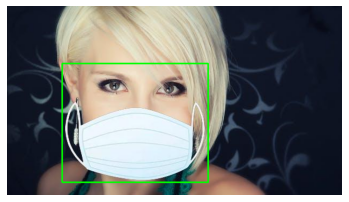

In [6]:
# checking one image
color_img = cv.imread("data/obj/5-with-mask.jpg")
temp_img = cv.imread("data/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)
color_img = cv.cvtColor(color_img, cv.COLOR_BGR2RGB)

cv.rectangle(color_img, (int(box[0]*(622/244)),int(box[1]*(350/244))), (int(box[2]*(622/244)+box[0]*(622/244)), int(box[3]*(350/244)+box[1]*(350/244))), (0, 255, 0), 2)
plt.imshow(color_img)
plt.axis("off")
plt.show()

### Creating tensorflow dataset with the images.

In [7]:
# defining function to create tensorflow dataset
def data_load(files, full_data_path = "data/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [8]:
# tensorflow training data
raw_train_ds = data_load(training_files)

In [9]:
# tensorflow validation data
raw_validation_ds = data_load(validation_files)

In [10]:
# tensorflow test data
raw_test_ds = data_load(test_files)

Setting up training, validation & test datasets according to tensorflow guideline.

In [11]:
# there are total 2 classes. 0 for mask and 1 for non mask
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [12]:
# taking batch size of 32
BATCH_SIZE = 32

# tuning training data
def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat(500) # The dataset be repeated 500 times
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
train_ds = tune_training_ds(raw_train_ds)

In [14]:
# tuning validation data
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat(500)
    return dataset

In [15]:
validation_ds = tune_validation_ds(raw_validation_ds)

### Let's visualize few training data instances:

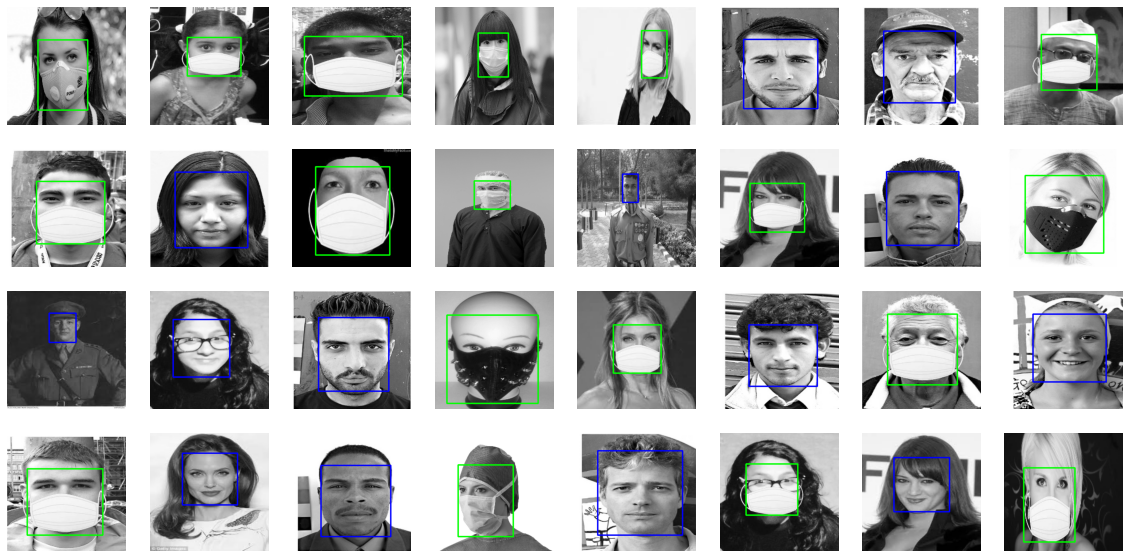

In [16]:
# plotting 32 images of training data
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255) # blue color for no mask
        if label[0] > 0:
            color = (0, 255, 0) # green color for mask

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Based on the image above, we can realize that the training dataset is correctly set. Blue rectangles represent bounding box of **unmask people**. A green rectangle represent a **masked person**.

## Building Model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Funcional API, as follows:

### Hyperparameter tuning using Keras Tuner

**Categorical Crossentropy** as loss for classification and **MSE** as loss for regression.

**Accuracy** as metric for classification and **MSE** as metric for regression.

In [24]:
# applying keras tuner for hyperparameter tuning
def build_model(hp):

    # inputs for input layer
    inputs = tf.keras.layers.Input(shape=(input_size, input_size, 1,))

    counter = 0

    for i in range(hp.Int('num_layers', min_value=1, max_value=15)):

        if counter == 0:
            # input layer followed by pooling layer
            x1 = tf.keras.layers.Conv2D(hp.Int('units' +str(i), min_value=8, max_value=128, step=2), kernel_size=3, activation=hp.Choice('activation' + str(i), values=['relu','tanh']), input_shape=(input_size, input_size, 1))(inputs)
            x2 = tf.keras.layers.AveragePooling2D(2,2)(x1)

        else:

            x3 = tf.keras.layers.Conv2D(hp.Int('units' +str(i), min_value=8, max_value=128, step=2), kernel_size=3, activation=hp.Choice('activation' + str(i), values=['relu','tanh']))(x2)
            x4 = tf.keras.layers.AveragePooling2D(2,2)(x3)
            x5 = tf.keras.layers.Dropout(hp.Choice('dropout' +str(i), values=[0.2,0.3,0.4,0.5,0.6,0.7,0.8]))(x4)
            x6 = tf.keras.layers.Flatten()(x5)
            x7 = tf.keras.layers.Dense(64, activation=hp.Choice('activation' + str(i), values=['relu','tanh']))(x6)

        counter += 1

    # defining two output heads, classification head and regressor head
    classification_head = tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(x7)
    regressor_head = tf.keras.layers.Dense(units = '4', name = 'regressor_head')(x7)
    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=hp.Choice('optimizer', values=['rmsprop','adam','adadelta','sgd']), loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [25]:
# hyperparameter tuning using Random Search
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=3, directory="mydir", project_name="final")

In [26]:
# running random search for 3 trials
tuner.search(train_ds, epochs=10, validation_data=validation_ds)

Trial 3 Complete [01h 56m 08s]
val_loss: 0.46532905101776123

Best val_loss So Far: 0.46532905101776123
Total elapsed time: 01h 56m 08s


In [27]:
# printing best possible hyperparameters
tuner.get_best_hyperparameters()[0].values

{'num_layers': 14,
 'units0': 32,
 'activation0': 'relu',
 'dropout0': 0.4,
 'optimizer': 'adadelta',
 'units1': 58,
 'activation1': 'relu',
 'dropout1': 0.3,
 'units2': 122,
 'activation2': 'tanh',
 'dropout2': 0.2,
 'units3': 100,
 'activation3': 'tanh',
 'dropout3': 0.6,
 'units4': 8,
 'activation4': 'relu',
 'dropout4': 0.2,
 'units5': 8,
 'activation5': 'relu',
 'dropout5': 0.2,
 'units6': 8,
 'activation6': 'relu',
 'dropout6': 0.2,
 'units7': 8,
 'activation7': 'relu',
 'dropout7': 0.2,
 'units8': 8,
 'activation8': 'relu',
 'dropout8': 0.2,
 'units9': 8,
 'activation9': 'relu',
 'dropout9': 0.2,
 'units10': 8,
 'activation10': 'relu',
 'dropout10': 0.2,
 'units11': 8,
 'activation11': 'relu',
 'dropout11': 0.2,
 'units12': 8,
 'activation12': 'relu',
 'dropout12': 0.2,
 'units13': 8,
 'activation13': 'relu',
 'dropout13': 0.2}

Above ouput suggests that there should be 14 number of layers, 32 filters, etc.

### Model Training

In [28]:
# let's train the model with best hyperparameters
model = tuner.get_best_models(num_models=1)[0]
EPOCHS = 1000

# applying early stopping in order to resist overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('ModelWeights/object_detection.h5', verbose = 1, save_best_only=True, monitor = 'val_loss')
lr_plat = tf.keras.callbacks.ReduceLROnPlateau(patience = 2, mode = 'min')

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS, initial_epoch=11, callbacks = [early_stopping, model_checkpoint, lr_plat])

Epoch 12/1000
27/28 [===========================>..] - ETA: 0s - loss: 0.2339 - classifier_head_loss: 0.1935 - regressor_head_loss: 0.0405 - classifier_head_accuracy: 0.9398 - regressor_head_mse: 0.0405
Epoch 12: val_loss improved from inf to 0.32343, saving model to ModelWeights/V1_Edge_Augmentation.h5
28/28 [==============================] - 3s 58ms/step - loss: 0.2364 - classifier_head_loss: 0.1956 - regressor_head_loss: 0.0408 - classifier_head_accuracy: 0.9353 - regressor_head_mse: 0.0408 - val_loss: 0.3234 - val_classifier_head_loss: 0.3012 - val_regressor_head_loss: 0.0222 - val_classifier_head_accuracy: 0.8148 - val_regressor_head_mse: 0.0222 - lr: 0.0010
Epoch 13/1000
27/28 [===========================>..] - ETA: 0s - loss: 0.2275 - classifier_head_loss: 0.1864 - regressor_head_loss: 0.0411 - classifier_head_accuracy: 0.9431 - regressor_head_mse: 0.0411
Epoch 13: val_loss improved from 0.32343 to 0.31585, saving model to ModelWeights/V1_Edge_Augmentation.h5
28/28 [============

We have training accuracy of 94% and validation accuracy of 81%.

### Model and its performance visualization

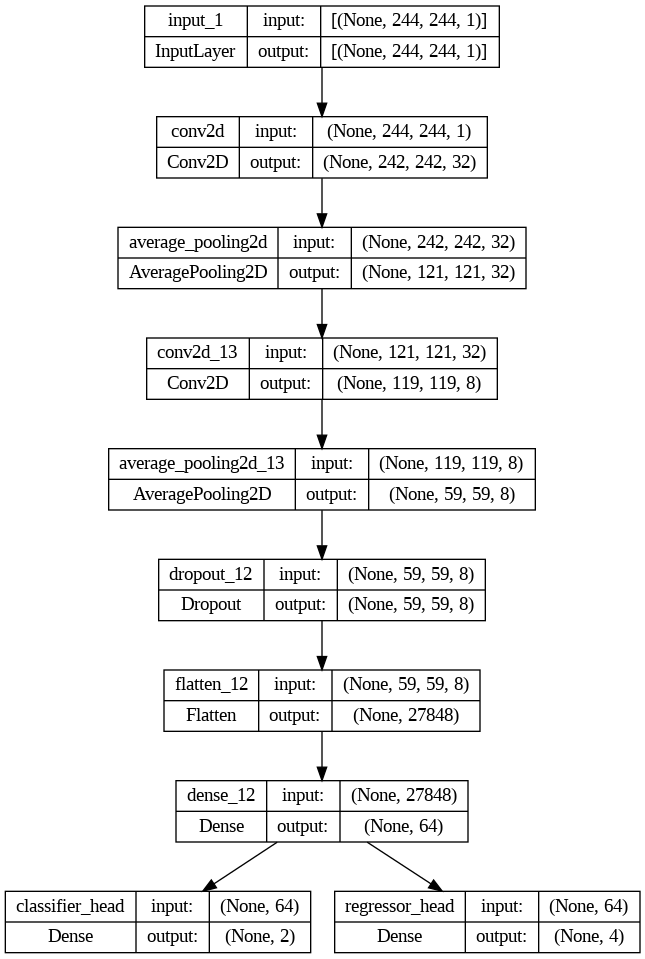

In [29]:
# plotting model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

The training performance can be checked in the charts below.

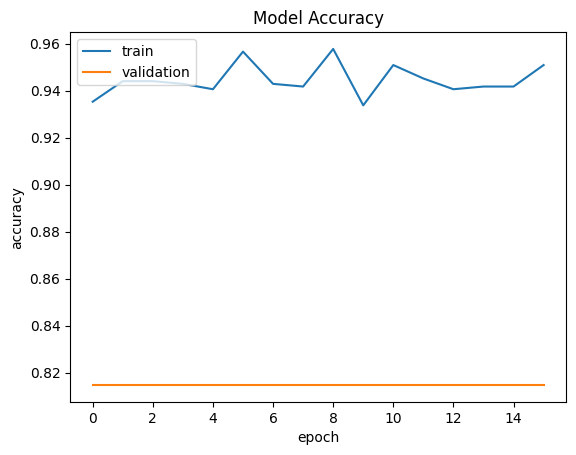

In [30]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

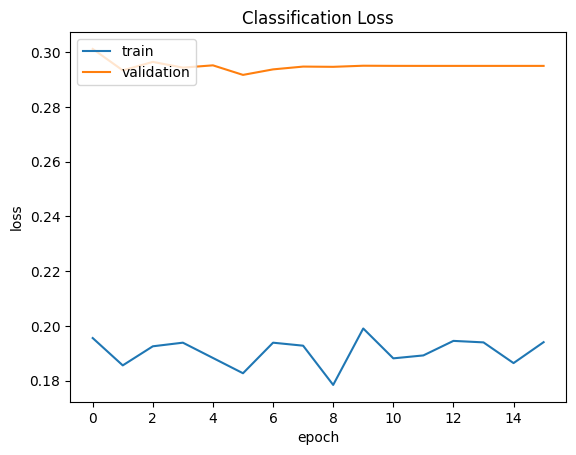

In [31]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

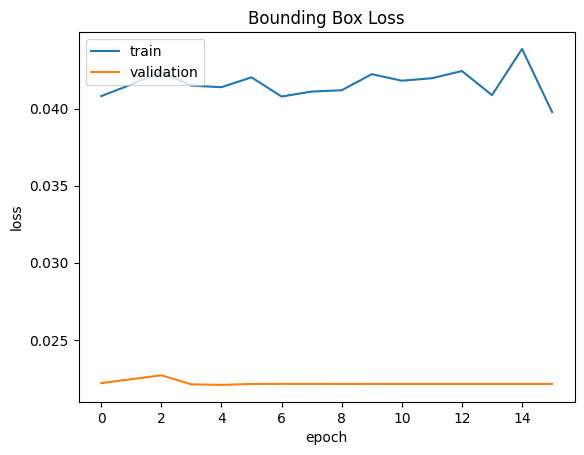

In [32]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

The best way to evaluate the end model performance is by using IoU - intersection over Union - metrics.

In [18]:
# defining function to calculate intersection over union
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [21]:
# tuning test dataset to evaluate performance of model
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat(1)
    return dataset

test_ds = tune_test_ds(raw_test_ds)

In [22]:
len(test_ds)

65

65


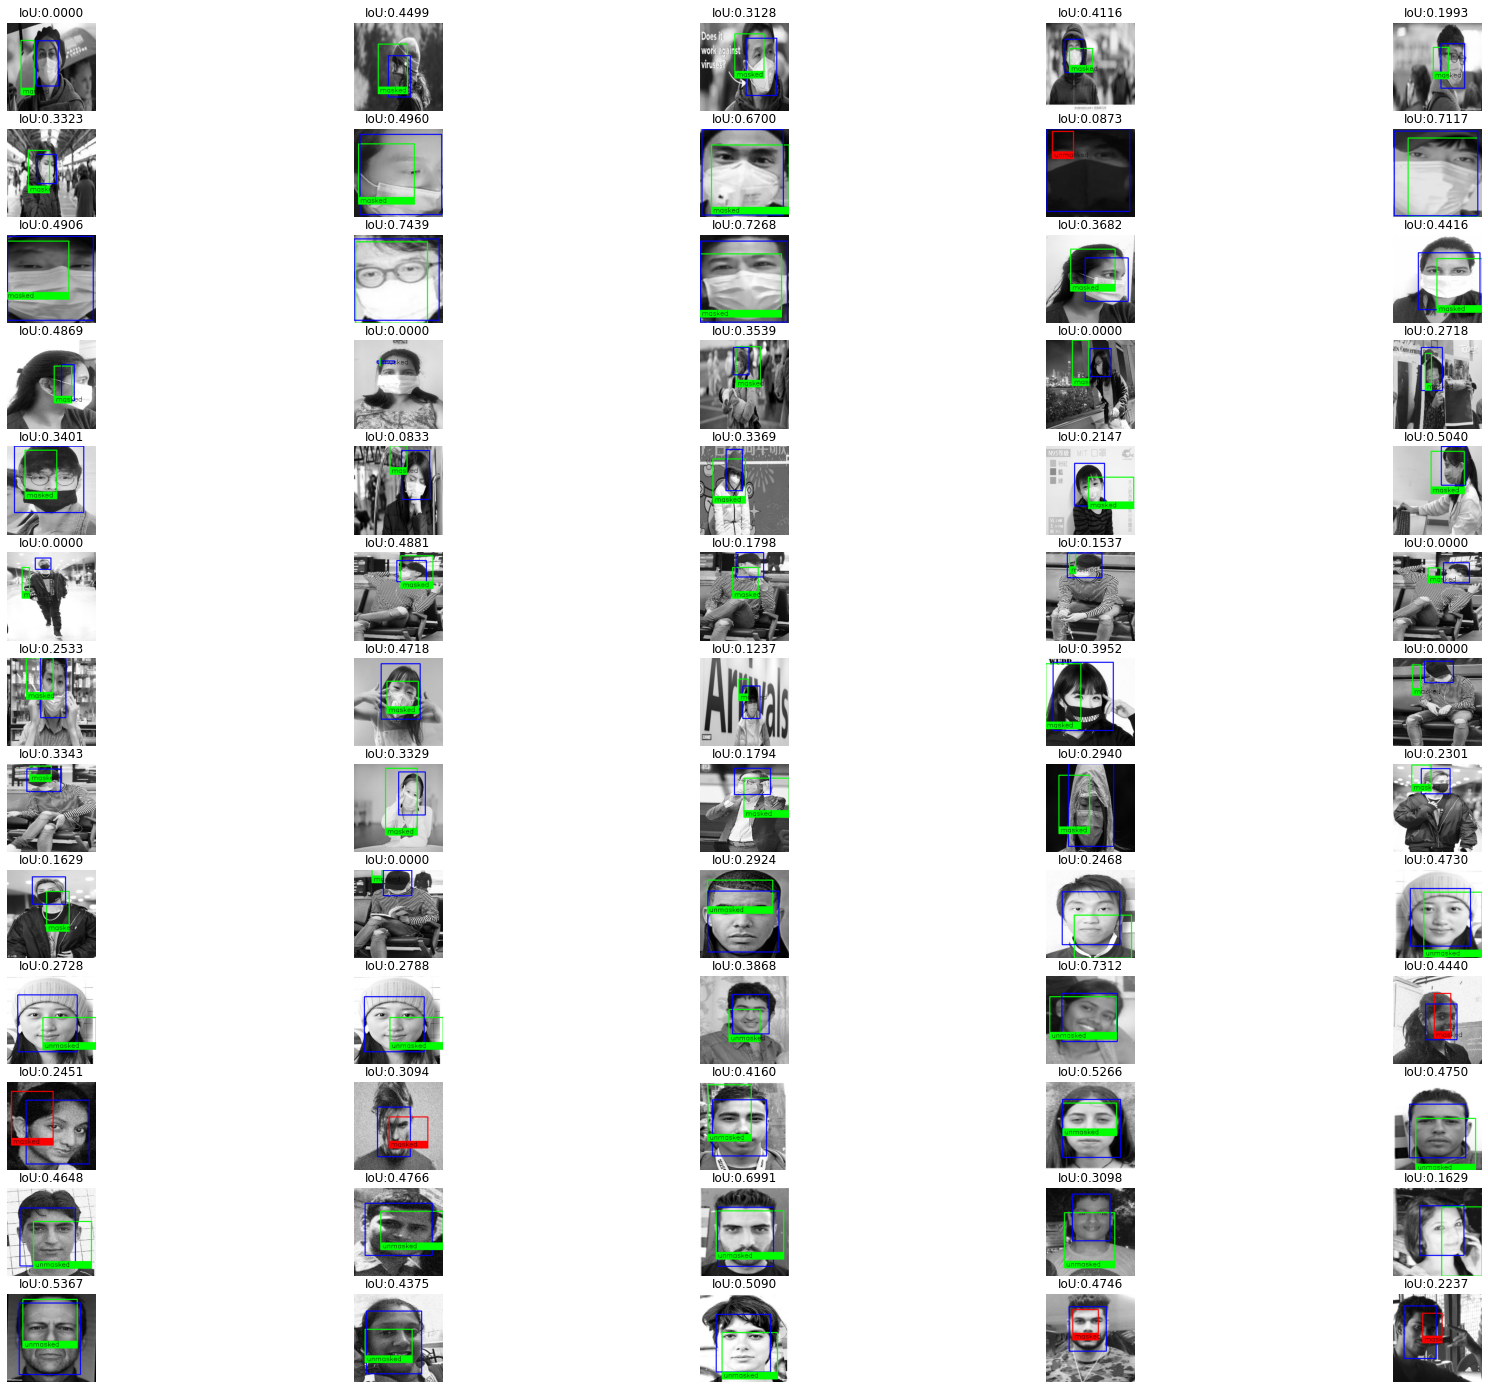

In [43]:
# evaluating model performance on test data by calculating IOU
plt.figure(figsize=(30, 25))

test_list = list(test_ds.as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(13, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]
    
    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

- Green boxes indicates correct classification in which the predicted label (masked-unmasked) matches with the actual label. A red box indicate a wrong classification.
- Blue boxes indicates target bounding boxes.
- IOU ranges from 0 to 1. 
- **0** means no overlapping and model performed really bad and **1** means complete overlapping and model performed really good.

### Evaluation Metric

**IOU (Intersection over Union)**
- If IOU > 0.5 and predicted object is true class, then this is True Positive(TP).
- If IOU < 0.5 , then its False Positive(FP).
- If there is no detection or IOU > 0.5 but prediction is wrong then its False Negative(FN).

**Precision** is equal to TP/(TP + FP). In words, of all bounding box predictions, what fraction was actually correct.

**Recall** is equal to TP/(TP +FN). In words, of all target bounding boxes, what fraction did we correctly detect.

In [51]:
# evaluating model performance on test data by calculating Precision and Recall
test_list = list(test_ds.as_numpy_iterator())
TP = 0
FP = 0
FN = 0

for i in range(len(test_list)):

    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_box_n = predicted_box.numpy()
    
    predicted_label = predictions[0][0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)
        
    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())
    
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        pass
    else:
        FN += 1
    
    if IoU > 0.5:
        TP += 1
        if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
            pass
        else:
            FN += 1
        
    else:
        FP += 1
        
precision = (TP/(TP + FP))*100
recall = (TP/(TP + FN))*100     

print(f"Precision is equal to {round(precision,2)} %")
print(f"Recall is equal to {round(recall,2)} %")

Precision is equal to 15.38 %
Recall is equal to 62.5 %


- The model performance is finally evaluated on the test dataset.
- We have achieved Precision equals to **15.38 %** and Recall equals to **62.5 %**.

## Conclusion

Taking in consideration the small size of the data used for training and the fact of training the model from scratch without transfer learning, we have got training accuracy of 94% and validation accuracy of 81%.
We can think in ways to improve it even more:

- The first option to improve the bound box and classificataion performance is increase the training data size.

- Trying more hyperparameters combinations for.eg. number of layers, number of neurons, activation function etc., can reduce the classification and regression errors.

- Instead of custom CNN architecture, Transfer Learning can be used to improve the accuracy of model.